In [16]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from PIL import Image
from datetime import datetime
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


*Note*: There are some other libraries that may be used to further enhance quality of the code. Some of these are, 

1. ipympl: Enables interactive matplotlib plots in jupyter

# Create Synthetic dataset

Synthetic dataset 1

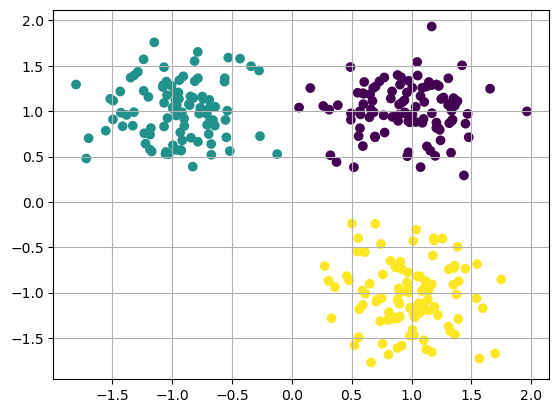

In [17]:
# cluster attributes (means and covariances)
mean1, cov1 = [1,1], [[0.1,0], [0,0.1]]
mean2, cov2 = [-1,1], [[0.1,0], [0,0.1]]
mean3, cov3 = [1, -1], [[0.1, 0], [0, 0.1]]

n = 100 # number of points per cluster

# generate samples
cluster1 = np.random.multivariate_normal(mean1, cov1, n)
cluster2 = np.random.multivariate_normal(mean2, cov2, n)
cluster3 = np.random.multivariate_normal(mean3, cov3, n)

# create dataset by concatenating all the clusters
X = np.vstack([cluster1, cluster2, cluster3]) # input
y = np.array(([0]*n, [1]*n, [2]*n)) # labels
y = y.flatten()

# visualize
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)
ax.grid(True)
plt.show()

# MLP

In [18]:
# base model
class MLP_sigmoid_1l(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MLP_sigmoid_1l, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H),
            nn.Sigmoid(),
            nn.Linear(H, D_out)
        )        
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

# 2-layered models
class MLP_sigmoid_2l(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(MLP_sigmoid_2l, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.Sigmoid(),
            nn.Linear(H1, H2),
            nn.Sigmoid(),
            nn.Linear(H2, D_out)
        )        
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred
    
class MLP_tanh_2l(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(MLP_tanh_2l, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.Tanh(),
            nn.Linear(H1, H2),
            nn.Tanh(),
            nn.Linear(H2, D_out)
        )        
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred
    
class MLP_ReLu_2l(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(MLP_ReLu_2l, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, D_out)
        )        
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

In [19]:
# sample_net = MLP_sigmoid_2l(2,3,3,3)
# sample_input = torch.randn(1, 2)
# sample_net(sample_input)

## Helper functions

In [20]:
class CustomDataset(Dataset):
    def __init__(self, data, loss_func):
        self.loss_func = loss_func
        X, y = data
        self.X, self.y = self.transforms(X, y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def transforms(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float)
        
        # Convert y to tensor based on specified loss function
        if self.loss_func == str.lower("cross entropy"):
            # For cross entropy loss, y should be of type torch.long (class labels)
            y_tensor = torch.tensor(y, dtype=torch.long)
        elif self.loss_func == str.lower("mse"):
            # For MSE loss, y should be a floating point tensor (continuous values)
            y_tensor = torch.tensor(y, dtype=torch.float)
        else:
            raise ValueError("Unsupported loss function specified.")
        
        return X_tensor, y_tensor
    
def CustomDataloader(dataset, training_portion, batch_size=10, shuffle=True):
    size = len(dataset)
    train_size = int(training_portion * size)
    val_size = size - train_size

    train_set, val_set = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size, shuffle)
    val_loader = DataLoader(val_set, batch_size, shuffle)
    
    return train_loader, val_loader

def train_loop(dataloader_tr, model, loss_fn, optimizer):
    model.train()
    epoch_loss = 0.0

    for batch_idx, data in enumerate(dataloader_tr):
        inputs, labels = data

        try:
            inputs = inputs.to(device)
            labels = labels.to(device)
        except ValueError:
            print("Error moving inputs and labels to gpu")
            
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        epoch_loss += loss.item()

        # backpropagation
        loss.backward()
        
        # update weights
        optimizer.step()
    
    # return loss over all batches and number of batches
    return epoch_loss, batch_idx+1

def test_loop(dataloader_val, model, loss_fn):
    model.eval()
    epoch_loss = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader_val):
            inputs, labels = data
            try:
                inputs = inputs.to(device)
                labels = labels.to(device)
            except ValueError:
                print("Error moving inputs and labels to gpu")

            outputs = model(inputs)
            loss = loss_fn(outputs, labels).item()
            epoch_loss += loss
    
    # return loss over all batches and number of batches
    return epoch_loss, batch_idx+1

def eval_classification(model, dataloader_val, training=True):
    model.eval()
    y_pred = []
    y_true = []
    conf_matrix = None
    
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_idx, data in enumerate(dataloader_val):
            inputs, labels = data
            try:
                inputs = inputs.to(device)
                labels = labels.to(device)
            except ValueError:
                print("Error moving inputs and labels to gpu")     

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            predicted = predicted.to('cpu')
            labels = labels.to('cpu')

            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())
            correct += (predicted == labels).sum().item()

    # compute metrics
    accuracy = 100 * correct / total
    f1 = f1_score(y_true, y_pred, average='weighted')

    if training == False:
        conf_matrix = confusion_matrix(y_true, y_pred)

    return accuracy, f1, conf_matrix

def log_gradients(model, model_name, writer, epoch):
    for name, parameter in model.named_parameters():
        if parameter.requires_grad and parameter.grad is not None:
            writer.add_histogram(f"{model_name}/_grad", parameter.grad, epoch)

def log_conf_matrix(writer, model_name, cm, epoch):
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues', ax=ax)
    plt.title('Confusion Matrix')
    plt.close(fig)

    writer.add_figure(f'{model_name}/Confusion Matrix', fig, epoch)

## Training loop

In [21]:
# # dataframe for storing metrics for all models
# results = dict()
# results['MLP_sigmoid_1l'] = {'training loss':[], 'validation loss':[], 'accuracy':[], 'f1':[]}
# results['MLP_sigmoid_2l'] = {'training loss':[], 'validation loss':[], 'accuracy':[], 'f1':[]}
# results['MLP_tanh_2l'] = {'training loss':[], 'validation loss':[], 'accuracy':[], 'f1':[]}
# results['MLP_relu_2l'] = {'training loss':[], 'validation loss':[], 'accuracy':[], 'f1':[]}

# results_df = pd.DataFrame(results)
# print(results_df)

In [26]:
# Train and test model
EPOCHS = 100

# models
models = [MLP_sigmoid_1l(2, 3, 3).to(device), 
          MLP_sigmoid_2l(2, 3, 3, 3).to(device),
          MLP_tanh_2l(2, 3, 3, 3).to(device),
          MLP_ReLu_2l(2, 3, 3, 3).to(device)]

# make optimizer for every model
optimizers = []
for i in range(len(models)):
    model = models[i]
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
    optimizers.append(optimizer)

criterion = nn.CrossEntropyLoss()

# createDataset
data = (X,y)
dataset = CustomDataset(data, "cross entropy")
train_loader, val_loader = CustomDataloader(dataset, 0.8, 10, True)

# Create tensorboard writers
model_names = ['mlp_sigmoid_1l', 'mlp_sigmoid_2l', 'mlp_tanh_2l', 'mlp_relu_2l']

# training
for i, model in enumerate(models):
    model_name = model_names[i]
    writer = SummaryWriter(log_dir=f"runs/{model_name}")

    for epoch in tqdm(range(EPOCHS)):

        # training
        training_loss, num_batches_tr = train_loop(dataloader_tr=train_loader,
                                                model=model,
                                                loss_fn=criterion,
                                                optimizer=optimizers[i]
                                                )
        
        # validation
        validation_loss, num_batches_v = test_loop(dataloader_val=val_loader,
                                                model=model,
                                                loss_fn=criterion)
        
        # evaluation
        accuracy, f1, conf_matrix = eval_classification(models[i], val_loader)

        # store performance in tensorboard
        writer.add_scalar(f'{model_name}/loss/train', training_loss/num_batches_tr, epoch)
        writer.add_scalar(f'{model_name}/loss/validation', validation_loss/num_batches_v, epoch)
        writer.add_scalar(f'{model_name}/accuracy', accuracy, epoch)
        writer.add_scalar(f'{model_name}/f1', f1, epoch)

    # Evaluate model
    accuracy, f1, conf_matrix = eval_classification(model, val_loader, training=False)

    log_gradients(model, model_name, writer, epoch) # log gradients
    log_conf_matrix(writer=writer, model_name=model_name, cm=conf_matrix, epoch=epoch) # log confusion matrix
    
    writer.close()



100%|██████████| 100/100 [00:10<00:00,  9.36it/s]


'mlp_relu_2l'

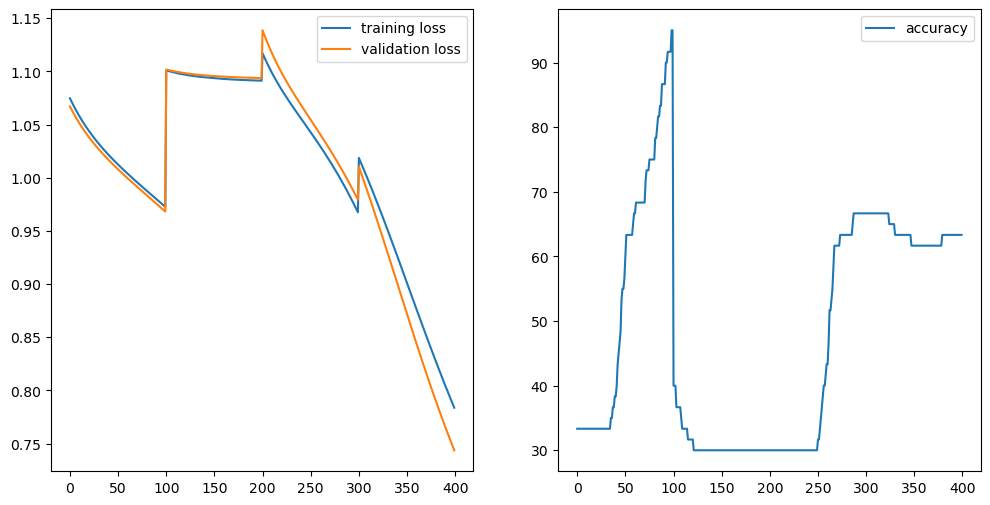

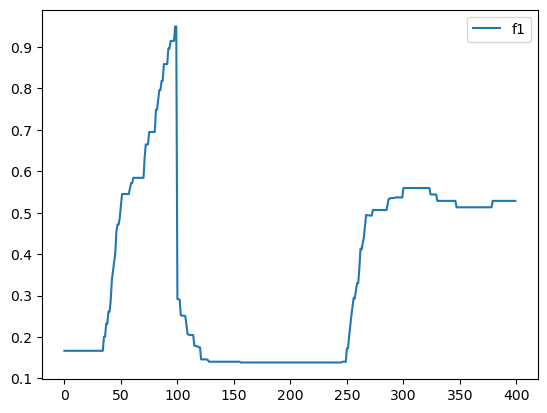

In [ ]:
# Plot losses 
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(epoch_mean_loss_tr, label='training loss')
ax[0].plot(epoch_mean_loss_v, label='validation loss')
ax[0].legend()

ax[1].plot(epoch_accuracies, label='accuracy')
ax[1].legend()
plt.show()

plt.figure()
plt.plot(epoch_f1, label='f1')
plt.legend()
plt.show()

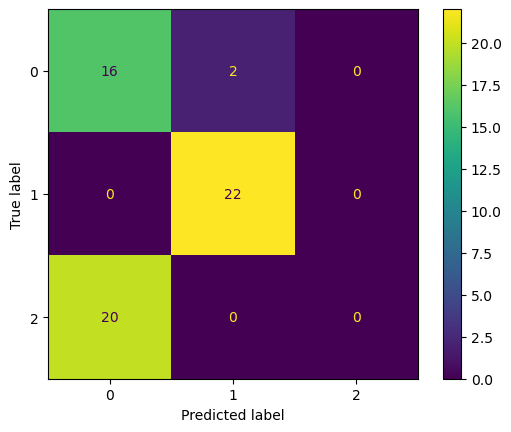

In [ ]:
conf_matrix

cm_display = ConfusionMatrixDisplay(conf_matrix).plot()

References

1. https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader
2. https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
3. https://hackernoon.com/how-to-structure-a-pytorch-ml-project-with-google-colab-and-tensorboard-7ram3agi

# CNN

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
class CNN(nn.Module):
    
    # this is our CNN initilization function     
    def __init__(self, size, num_classes):
        super(CNN, self).__init__()

        # here is our "feature extraction" via convolutional layers 
        #   note: assume we got a single channel (grayscale) MNIST image of size 28x28x1
        #         first layer
        #             28x28x1 -> convolution (1 stride, 1 padd, 3x3 kernel, 2 kernels) -> 28x28x2
        #         pooling
        #             pool of 2x2 => 28x28 / 2 => 14x14 now (technically, 14x14x2 right!)
        #         second layer
        #             14x14x2 -> convolution (1 stride, 1 padd, 3x3 kernel, 4 kernels) -> 14x14x4
        #         pooling
        #             pool of 2x2 => 14x14 / 2 => 7x7 now (technically, 7x7x4 right!)
        self.extract = nn.Sequential( # lets make a 2D convolution layer
                                      nn.Conv2d( in_channels = size, out_channels = 2, 
                                                 kernel_size = 3, stride = 1, padding = 1), 
                                                     # in_channels = 1 for MNIST and 3 for RGB image
                                                     # out_channels = 2 means 2 shared weights/features
                                                     # kernel_size = 3 means a 3x3 size kernel
                                                     # stride = 1 means move one pixel at a time in each dim
                                                     # padding = adds one pixel of zeros to each side of each dim
                                                     #           note, thats what keeps our spatial dims the same for a 3x3 kernel
                                                     #           it also lets us process each location, even that border!!!
                                      # its a NN, lets run a non-linearity on each of those results!
                                      nn.ReLU(inplace = True),
                                                     # could also use torch.nn.Sigmoid or etc.
                                                     # inplace means don't have to return a result, do it on the data
                                      # ----------------------------------------------------------- 
                                      # !!! hey, we just made a layer of convolution/nonlin !!!
                                      # ----------------------------------------------------------- 
                                      # lets pool using a 2x2 region that is not overlapping
                                      nn.MaxPool2d(2),                                                  
                                      # lets do dropout with a small percentage/rate               
                                      nn.Dropout(0.1),
                                      # ----------------------------------------------------------- 
                                      # now, lets make another layer of convolution, pooling, and drop out
                                      nn.Conv2d( in_channels = 2, out_channels = 4, 
                                                 kernel_size = 3, stride = 1, padding = 1),
                                                 # in_channels here needs to match out_channels above
                                                 # lets use 5 filters 
                                      nn.ReLU(inplace = True),
                                      nn.MaxPool2d(2),
                                      nn.Dropout(0.1), )

        # ok, now we are going to make a simple MLP classifier on the end of our above features
        self.decimate = nn.Sequential( nn.Linear(4*(7*7), 12),  
                                            # take our 4 filters whose response fields are 7x7 to 12 neurons
                                       nn.ReLU(inplace = True), # run a nonlinearity
                                       nn.Dropout(0.2), # some drop out
                                       nn.Linear(12, num_classes) ) # map the 32 down to our number of output classes
 
    #----------------------------
    # Model: Invoke Forward Pass
    #----------------------------

    def forward(self, x):

        features = self.extract(x) # easy, pass input (x) to our "feature extraction" above
        features = features.view(features.size()[0], -1) # now, flatten 7x7x4 matrix to 1D array of 7*7*4 size
        myresult = self.decimate(features) # pass that to our MLP classifier, and done!!!

        return myresult

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_set = datasets.MNIST(root="data",
                  train=True,
                  download=True,
                  transform=ToTensor())

val_set = datasets.MNIST(root="data",
                 train=False,
                 download=True,
                 transform=ToTensor())

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

In [ ]:
# Train and test model
EPOCHS = 100
input_size = 1
classes = 10
model = CNN(input_size, classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

epoch_mean_loss_tr = []
epoch_mean_loss_v = []
epoch_accuracies = []
epoch_f1 = []

for epoch in tqdm(range(EPOCHS)):

    # training
    training_loss, num_batches_tr = train_loop(dataloader_tr=train_loader,
                                               model=model,
                                               loss_fn=criterion,
                                               optimizer=optimizer)
    
    # validation
    validation_loss, num_batches_v = test_loop(dataloader_val=val_loader,
                                               model=model,
                                               loss_fn=criterion)
    
    # evaluation
    accuracy, f1, conf_matrix = eval_classification(model, val_loader)

    # store performance
    epoch_accuracies.append(accuracy)
    epoch_f1.append(f1)
    epoch_mean_loss_tr.append(training_loss/num_batches_tr)
    epoch_mean_loss_v.append(validation_loss/num_batches_v)

# Evaluate model
accuracy, f1, conf_matrix = eval_classification(model, val_loader, training=False)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [28:09<00:00, 16.90s/it]


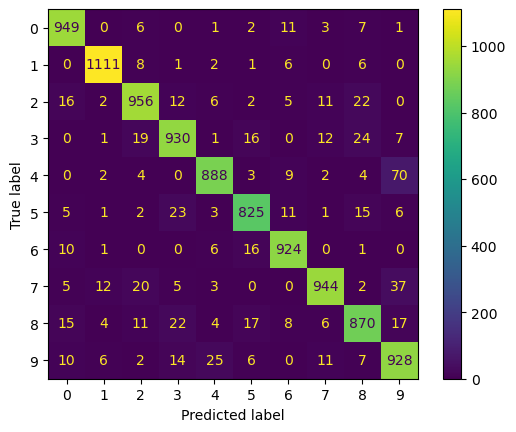

In [ ]:
cm_display = ConfusionMatrixDisplay(conf_matrix).plot()